In [ ]:
!pip install -q "tensorflow==2.11.*"
!pip install -q "tensorflow_io==0.28.*"

In [119]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import wave
import csv
import shutil
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

In [3]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [4]:
@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav=tf.squeeze(wav,axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [5]:
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])

In [137]:
_ = tf.keras.utils.get_file('car.zip',
                        'https://github.com/Boden448/Sound/archive/main.zip',

                        cache_dir='./',
                        cache_subdir='madds',
                        extract=True)

   8192/Unknown - 0s 0us/step

In [144]:
df1 = pd.read_csv('./madds/Sound-main/meta/complete0.csv')
df2 = pd.read_csv('./madds/Sound-main/meta/complete1.csv')

merge_df = pd.concat([df1, df2], ignore_index=True)

merge_df.to_csv('./madds/Sound-main/meta/complete1.csv', index=False)

In [131]:
source_dir='./madds/Sound-main/datasets/train'
dest_dir='./madds/Sound-main/datasets/dog'
base_data_path='./madds/Sound-main/datasets/all_audio_files'


In [132]:
os.makedirs(new_dir, exist_ok=True)

for root, dirs, files in os.walk(source_dir):
    for file in files:
        if file.endswith('.wav'):
            shutil.move(os.path.join(root, file), dest_dir)

for file in os.listdir(dest_dir):
    if file.endswith('.wav'):
        shutil.move(os.path.join(dest_dir, file), new_dir)

In [101]:
#meta_csv='./madds/Sound-main/meta/car.csv'
#base_data_path='./madds/Sound-main/datasets/'

In [147]:
pd_data = pd.read_csv('./madds/Sound-main/meta/complete1.csv')
pd_data.head()

,filename,fold,target,category,risk
0,bird0.wav,1,5,bird,low
1,bird1.wav,1,5,bird,low
2,bird10.wav,1,5,bird,low
3,bird100.wav,1,5,bird,low
4,bird1000.wav,1,5,bird,low


In [148]:
my_classes = ['horn','start','break','cat','siren','bird','construction','barrier','crowd']
map_class_to_id = {'horn':0,'start':1,'break':2,'cat':3,'siren':4,'bird':5,'construction':6,'barrier':7,'crowd':8}

filtered_pd = pd_data[pd_data.category.isin(my_classes)]

class_id = filtered_pd['category'].apply(lambda name: map_class_to_id[name])
filtered_pd = filtered_pd.assign(target=class_id)

full_path = filtered_pd['filename'].apply(lambda row: os.path.join(base_data_path, row))
filtered_pd = filtered_pd.assign(filename=full_path)

filtered_pd.head(10)

,filename,fold,target,category,risk
0,./madds/Sound-main/datasets/bird0.wav,1,5,bird,low
1,./madds/Sound-main/datasets/bird1.wav,1,5,bird,low
2,./madds/Sound-main/datasets/bird10.wav,1,5,bird,low
3,./madds/Sound-main/datasets/bird100.wav,1,5,bird,low
4,./madds/Sound-main/datasets/bird1000.wav,1,5,bird,low
5,./madds/Sound-main/datasets/bird1001.wav,1,5,bird,low
6,./madds/Sound-main/datasets/bird1002.wav,1,5,bird,low
7,./madds/Sound-main/datasets/bird1003.wav,1,5,bird,low
8,./madds/Sound-main/datasets/bird1004.wav,1,5,bird,low
9,./madds/Sound-main/datasets/bird1005.wav,1,5,bird,low


In [104]:
filenames = filtered_pd['filename']
targets = filtered_pd['target']
folds = filtered_pd['fold']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [105]:
def load_wav_for_map(filename, label, fold):
    return load_wav_16k_mono(filename), label, fold

main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [106]:
def extract_embedding(wav_data, label, fold):
    ''' run YAMNet to extract embedding from the wav data '''
    scores, embeddings, spectrogram = yamnet_model(wav_data)
    num_embeddings = tf.shape(embeddings)[0]
    return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [107]:
cached_ds = main_ds.cache()
train_ds = cached_ds.filter(lambda embedding, label, fold: fold < 4)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 4)
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == 5)

remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(64).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(64).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(64).prefetch(tf.data.AUTOTUNE)


In [108]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float64,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='softmax'),
    tf.keras.layers.Dense(len(my_classes))
], name='my_model')

my_model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 512)               524800    
                                                                 
 dense_9 (Dense)             (None, 9)                 4617      
                                                                 
Total params: 529,417
Trainable params: 529,417
Non-trainable params: 0
_________________________________________________________________


In [109]:
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])


callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=4,
                                            baseline=None,
                                            restore_best_weights=True)



In [111]:
for i in range(1):
    history = my_model.fit(train_ds,
                           epochs=400,
                           validation_data=val_ds,
                           callbacks=callback)
    


Epoch 1/400


NotFoundError: Graph execution error:

NewRandomAccessFile failed to Create/Open: ./madds/Sound-main/datasets/break1.wav : The system cannot find the file specified.
; No such file or directory
	 [[{{node ReadFile}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_70434]

In [ ]:
class ReduceMeanLayer(tf.keras.layers.Layer):
    def __init__(self, axis=0, **kwargs):
        super(ReduceMeanLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, input):
        return tf.math.reduce_mean(input, axis=self.axis)

In [27]:
testing_wav_file_name = tf.keras.utils.get_file('miaow_16k.wav',
                                                'https://storage.googleapis.com/audioset/miaow_16k.wav',
                                                cache_dir='./',
                                                cache_subdir='test_data')

print(testing_wav_file_name)

testing_wav_data = load_wav_16k_mono(testing_wav_file_name)

./test_data\miaow_16k.wav


In [28]:
class ReduceMeanLayer(tf.keras.layers.Layer):
    def __init__(self, axis=0, **kwargs):
        super(ReduceMeanLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, input):
        return tf.math.reduce_mean(input, axis=self.axis)

In [29]:
saved_model_path = './dogs_cos_pigs'

input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')
embedding_extraction_layer = hub.KerasLayer(yamnet_model_handle,
                                            trainable=False, name='yamnet')
_, embeddings_output, _ = embedding_extraction_layer(input_segment)
serving_outputs = my_model(embeddings_output)
serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)
serving_model = tf.keras.Model(input_segment, serving_outputs)
serving_model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: ./dogs_cos_pigs\assets


INFO:tensorflow:Assets written to: ./dogs_cos_pigs\assets


In [30]:
reloaded_model = tf.saved_model.load(saved_model_path)

./madds/Sound-main/photo/horn23.wav
Waveform values: [ 1.8263467e-08 -5.2372911e-08  3.4907497e-08 ...  1.6641632e-02
  1.1462305e-02 -1.4974890e-02]


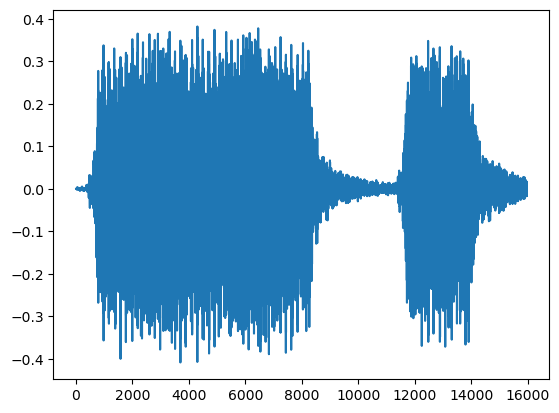

In [57]:
test_pd = filtered_pd.loc[filtered_pd['fold'] == 1]
row = test_pd.sample(1)
risk = row['risk'].item()
filename = row['filename'].item()
print(filename)
waveform = load_wav_16k_mono(filename)
print(f'Waveform values: {waveform}')
_ = plt.plot(waveform)

display.Audio(waveform, rate=16000)

In [58]:
reloaded_results = reloaded_model(waveform)
your_top_class = tf.math.argmax(reloaded_results)
your_inferred_class = my_classes[your_top_class]
class_probabilities = tf.nn.softmax(reloaded_results, axis=-1)
your_top_score = class_probabilities[your_top_class]
print(f'[Your model] The main sound is: {your_inferred_class} ({your_top_score})')
print(f'risk level: {risk}')

[Your model] The main sound is: horn (0.5241820812225342)
risk level: medium
